<a href="https://colab.research.google.com/github/JimohAR/it_core_project1/blob/main/notebooks/task1_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [18]:
data = pd.read_csv(path + "telco.csv").iloc[:-1]

In [19]:
desc = pd.read_excel(path + "field_descriptions.xlsx").set_index("Fields")

In [2]:
# from . import task_exp
# /root/it_core_project1/scripts

## User Overview Analysis
* Start by identifying the top 10 handsets used by the customers.

* Then, identify the top 3 handset manufacturers

* Next, identify the top 5 handsets per top 3 handset manufacturer

* Make a short interpretation and recommendation to marketing teams

## Task 1.1
Aggregate per user the following information in the column  
- number of xDR sessions
- session duration
- the total download (DL) and upload (UL) data
- the total data volume (in Bytes) during this session for each application

In [29]:
data["MSISDN/Number"] = data["MSISDN/Number"].fillna(-999).astype("int")

In [30]:
no_of_xdr_sessions = data["MSISDN/Number"].fillna("median").value_counts()

In [31]:
total_sessions_duration = (data[["MSISDN/Number", "Dur. (ms)"]]
                           .fillna("median").groupby(["MSISDN/Number"])["Dur. (ms)"]
                           .sum()
                          )/(60*60)

In [32]:
total_dl_ul_data = (data[["MSISDN/Number", "Total DL (Bytes)", "Total UL (Bytes)"]]
                    .fillna("median").groupby(["MSISDN/Number"])[["Total DL (Bytes)", "Total UL (Bytes)"]]
                    .sum()
                   )/(2**20)

In [33]:
total_dl_ul_data["total_data"] = total_dl_ul_data.sum(1)

In [34]:
apps = ['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
       'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)',
       'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
       'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)',
       'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)',]

In [35]:
total_dl_ul_data_per_app = (data[apps + ["MSISDN/Number"]].fillna("mean")
                            .groupby(["MSISDN/Number"])[apps].sum()
                           )/(2**20)

In [36]:
total_data_per_app = pd.DataFrame()
count = 0
for i,j in zip(range(len(total_dl_ul_data_per_app.columns)), total_dl_ul_data_per_app.columns):
    if count != 1:
        total_data_per_app[j.split()[0]] = total_dl_ul_data_per_app.iloc[:, i] + total_dl_ul_data_per_app.iloc[:,i+1]
        count = (count + 1) % 2
    else: 
        count = (count + 1) % 2
        continue

In [37]:
aggregates = (no_of_xdr_sessions.to_frame()
              .join(total_sessions_duration)
              .join(total_data_per_app)
              .join(total_dl_ul_data)
             )

In [38]:
aggregates.index.name = "MSISDN"
aggregates.columns = ["tot number of session", "tot sessions duration (hrs)", "social media data usage (MBs)",
                      "google data usage (MBs)","Email data usage (MBs)", "youtube data usage (MBs)", 
                      "netflix data usage (MBs)",  "gaming apps data usage (MBs)", "other apps data usage (MBs)", 
                      "tot downloaded data (MBs)", "tot uploaded data (MBs)", "tot data usage (MBs)",]
aggregates = aggregates.drop(index = -999)

In [39]:
aggregates.describe().style#.set_properties(**{"width": "100px"})

,tot number of session,tot sessions duration (hrs),social media data usage (MBs),google data usage (MBs),Email data usage (MBs),youtube data usage (MBs),netflix data usage (MBs),gaming apps data usage (MBs),other apps data usage (MBs),tot downloaded data (MBs),tot uploaded data (MBs),tot data usage (MBs)
count,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000
mean,1.393792,40.601988,2.429931,10.378298,3.002926,30.096435,30.077298,571.984301,570.782437,604.298287,54.654524,658.952812
std,0.806022,51.766297,1.819647,7.195341,2.119446,20.308416,20.303304,428.343260,428.125486,443.034226,34.005785,468.307391
min,1.000000,1.983889,0.001491,0.038462,0.017334,0.075248,0.176019,0.292166,0.142140,8.418161,2.734081,31.708726
25%,1.000000,19.807778,1.155168,5.667339,1.596910,17.767991,17.696355,274.718392,272.331153,300.242485,34.709430,341.939838
50%,1.000000,28.538889,2.197033,9.142068,2.670121,25.558830,25.481119,517.224509,514.824241,543.945048,44.626108,589.297426
75%,2.000000,47.999722,3.154286,12.602558,3.668973,36.170936,36.217649,741.294992,739.476710,769.962778,62.686913,817.713878
max,18.000000,5153.820556,41.365413,145.141460,40.453703,431.975144,381.011085,7390.434488,7789.495255,7778.876775,695.779209,8436.419004


###### removing outliers : any user with session duration greater than (30*12) mins 

In [40]:
outliers_index = \
aggregates["tot sessions duration (hrs)"][aggregates["tot sessions duration (hrs)"] > (30*12)].keys()
aggregates.loc[outliers_index] = np.nan
aggregates.dropna(inplace=True)

In [41]:
aggregates.describe().style

,tot number of session,tot sessions duration (hrs),social media data usage (MBs),google data usage (MBs),Email data usage (MBs),youtube data usage (MBs),netflix data usage (MBs),gaming apps data usage (MBs),other apps data usage (MBs),tot downloaded data (MBs),tot uploaded data (MBs),tot data usage (MBs)
count,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000
mean,1.379986,38.945798,2.406328,10.273692,2.972841,29.795385,29.777472,566.283479,565.158929,598.270156,54.113350,652.383505
std,0.751298,34.344976,1.744367,6.838355,2.016566,19.260624,19.266514,409.946436,410.941550,423.254635,31.994931,446.221514
min,1.000000,1.983889,0.001491,0.038462,0.017334,0.075248,0.176019,0.292166,0.142140,8.418161,2.734081,31.708726
25%,1.000000,19.710625,1.152503,5.656567,1.593564,17.742988,17.674101,274.037992,271.572208,299.494924,34.676584,341.003925
50%,1.000000,28.456111,2.191891,9.124181,2.664310,25.511245,25.433387,515.971701,513.621295,542.765436,44.576648,587.853882
75%,2.000000,47.999722,3.146709,12.565546,3.659199,36.047137,36.091989,739.504440,737.657516,767.978338,62.295820,815.835433
max,11.000000,359.504444,22.698244,83.574781,21.861470,237.480580,222.896995,4343.421737,4392.022408,4545.041459,435.936921,4860.047088


## Task 1.2

○	Describe all relevant variables and associated data types (slide). 

○	Analyze the basic metrics (mean, median, etc) in the Dataset (explain) & their importance for the global objective.

○	Conduct a Non-Graphical Univariate Analysis by computing dispersion parameters for each quantitative variable and providing useful interpretation. 

○	Conduct a Graphical Univariate Analysis by identifying the most suitable plotting options for each variable and interpreting your findings.

○	Bivariate Analysis – explore the relationship between each application & the total DL+UL data using appropriate methods and interpret your findings. 

○	Variable transformations – segment the users into the top five decile classes based on the total duration for all sessions and compute the total data (DL+UL) per decile class. 

○	Correlation Analysis – compute a correlation matrix for the following variables and interpret your findings: Social Media data, Google data, Email data, Youtube data, Netflix data, Gaming data, Other data 

○	Dimensionality Reduction – perform a principal component analysis to reduce the dimensions of your data and provide a useful interpretation of the results (Provide your interpretation in four (4) bullet points-maximum). 


In [42]:
aggregates.dtypes

tot number of session            float64
tot sessions duration (hrs)      float64
social media data usage (MBs)    float64
google data usage (MBs)          float64
Email data usage (MBs)           float64
youtube data usage (MBs)         float64
netflix data usage (MBs)         float64
gaming apps data usage (MBs)     float64
other apps data usage (MBs)      float64
tot downloaded data (MBs)        float64
tot uploaded data (MBs)          float64
tot data usage (MBs)             float64
dtype: object

In [43]:
ss = aggregates.describe().loc[["mean", "min", "50%", "75%", "max"]].T

In [44]:
ss.style.set_precision(2).set_properties(**{"width": "100px", "color": "blue"})

,mean,min,50%,75%,max
tot number of session,1.38,1.00,1.00,2.00,11.00
tot sessions duration (hrs),38.95,1.98,28.46,48.00,359.50
social media data usage (MBs),2.41,0.00,2.19,3.15,22.70
google data usage (MBs),10.27,0.04,9.12,12.57,83.57
Email data usage (MBs),2.97,0.02,2.66,3.66,21.86
youtube data usage (MBs),29.80,0.08,25.51,36.05,237.48
netflix data usage (MBs),29.78,0.18,25.43,36.09,222.90
gaming apps data usage (MBs),566.28,0.29,515.97,739.50,4343.42
other apps data usage (MBs),565.16,0.14,513.62,737.66,4392.02
tot downloaded data (MBs),598.27,8.42,542.77,767.98,4545.04


In [45]:
# aggregates.iloc[:,:1].boxplot(figsize= (20,10), whis= (0,100))

In [46]:
# aggregates.iloc[:,1:2].boxplot(figsize= (20,10), whis= (0,100))

In [47]:
# aggregates.iloc[:,2:7].boxplot(figsize= (20,10), whis= (0,100))

In [48]:
# aggregates.iloc[:,7:12].boxplot(figsize= (20,10), whis= (0,100))

In [49]:
sessions_and_data_used_sorted = \
(aggregates[["tot sessions duration (hrs)", "tot data usage (MBs)"]]
 .sort_values(["tot sessions duration (hrs)"], ascending= False)
)

In [50]:
sessions_binned = pd.qcut(sessions_and_data_used_sorted.iloc[:,0], 10, labels=np.arange(10))
sessions_binned.name = "sessions_bin_class"

In [51]:
tot_sessions_and_data_used_binned = (sessions_and_data_used_sorted.join(sessions_binned)
                                     .groupby("sessions_bin_class").aggregate("mean")
                                    )

In [52]:
tot_sessions_and_data_used_binned

,tot sessions duration (hrs),tot data usage (MBs)
sessions_bin_class,,
0,5.567984,485.476552
1,11.143625,544.368834
2,19.699618,581.556603
3,23.990098,476.309916
4,26.147770,531.532518
5,32.491201,573.819973
6,40.890934,548.189196
7,48.434390,694.320787
8,64.085545,827.252899


In [53]:
aggregates.describe()

,tot number of session,tot sessions duration (hrs),social media data usage (MBs),google data usage (MBs),Email data usage (MBs),youtube data usage (MBs),netflix data usage (MBs),gaming apps data usage (MBs),other apps data usage (MBs),tot downloaded data (MBs),tot uploaded data (MBs),tot data usage (MBs)
count,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000,106554.000000
mean,1.379986,38.945798,2.406328,10.273692,2.972841,29.795385,29.777472,566.283479,565.158929,598.270156,54.113350,652.383505
std,0.751298,34.344976,1.744367,6.838355,2.016566,19.260624,19.266514,409.946436,410.941550,423.254635,31.994931,446.221514
min,1.000000,1.983889,0.001491,0.038462,0.017334,0.075248,0.176019,0.292166,0.142140,8.418161,2.734081,31.708726
25%,1.000000,19.710625,1.152503,5.656567,1.593564,17.742988,17.674101,274.037992,271.572208,299.494924,34.676584,341.003925
50%,1.000000,28.456111,2.191891,9.124181,2.664310,25.511245,25.433387,515.971701,513.621295,542.765436,44.576648,587.853882
75%,2.000000,47.999722,3.146709,12.565546,3.659199,36.047137,36.091989,739.504440,737.657516,767.978338,62.295820,815.835433
max,11.000000,359.504444,22.698244,83.574781,21.861470,237.480580,222.896995,4343.421737,4392.022408,4545.041459,435.936921,4860.047088


In [54]:
sessions_and_data_used_sorted.duplicated(["tot sessions duration (hrs)"]).sum()

29318

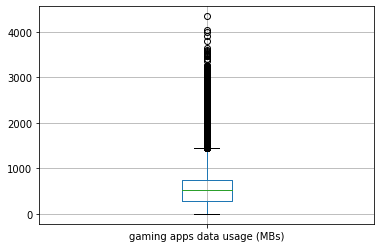

In [55]:
aggregates[["gaming apps data usage (MBs)"]].boxplot()

In [56]:
(aggregates["tot sessions duration (hrs)"] > 360).sum()

0

In [57]:
12 * 30

360

In [58]:
data[['Dur. (ms).1']].duplicated().sum()

27129

In [59]:
data.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [60]:
aggregates[["tot sessions duration (hrs)"]]

,tot sessions duration (hrs)
MSISDN,
33669068942,169.666944
33665083783,240.018333
33650426463,214.266111
33666169635,166.000000
33646181976,347.178889
...,...
33660334768,42.762778
33761969553,35.785556
33634114229,44.094167


In [61]:
data.max()

Bearer Id                                       1.31865e+19
Start                                         4/9/2019 9:47
Start ms                                                999
End                                          4/30/2019 9:59
End ms                                                  999
Dur. (ms)                                       1.85934e+06
IMSI                                            2.14074e+14
MSISDN/Number                               882397108489451
IMEI                                            9.90012e+13
Avg RTT DL (ms)                                       96923
Avg RTT UL (ms)                                        7120
Avg Bearer TP DL (kbps)                              378160
Avg Bearer TP UL (kbps)                               58613
TCP DL Retrans. Vol (Bytes)                     4.29443e+09
TCP UL Retrans. Vol (Bytes)                     2.90823e+09
DL TP < 50 Kbps (%)                                     100
50 Kbps < DL TP < 250 Kbps (%)          

In [62]:
81479/60/24

56.58263888888889